In [1]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [2]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk

In [4]:
df = pd.read_csv('Tshirt.csv')
print(df.shape)
df = df.head(500)
print(df.shape)


(137, 9)
(137, 9)


In [5]:
example = df['Review Title'][50]
print(example)

Nice product


In [6]:
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.010233999, 'roberta_neu': 0.09647464, 'roberta_pos': 0.89329135}


In [7]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [9]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [10]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = str(row['Review Title'])
    myid = str(row['Id'])
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/137 [00:00<?, ?it/s]

In [11]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(df, how='left')

ValueError: You are trying to merge on object and int64 columns. If you wish to proceed you should use pd.concat

In [12]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})

# Convert the 'Id' column to float64 type in the 'vaders' DataFrame
vaders['Id'] = vaders['Id'].astype(float)

# Convert the 'Id' column to float64 type in the 'df' DataFrame
df['Id'] = df['Id'].astype(float)

# Merge the DataFrames
vaders = pd.concat([vaders, df], axis=1)


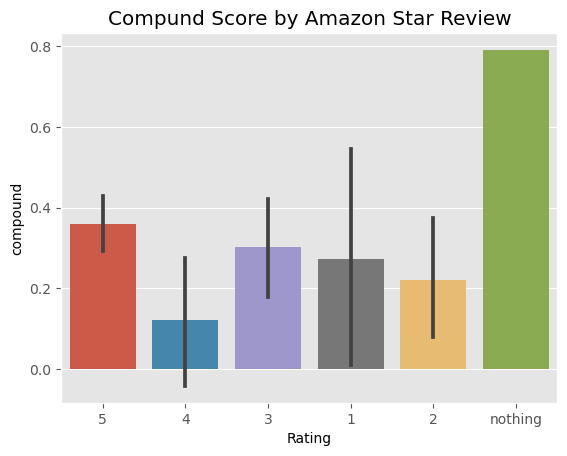

In [13]:
ax = sns.barplot(data=vaders, x='Rating', y='compound')
ax.set_title('Compund Score by Amazon Star Review')
plt.show()

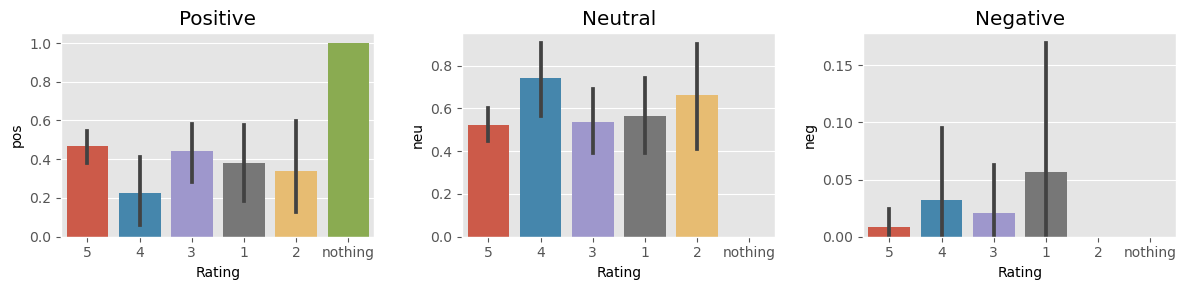

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='Rating', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Rating', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Rating', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

In [17]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Review Title']
        myid = row['Id']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/137 [00:00<?, ?it/s]

In [18]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(df, how='left')

In [19]:
results_df.columns

Index(['Id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'ASIN', 'Rating',
       'Review Title', 'Review', 'Product Name', 'Brand', 'Category',
       'Outfit type'],
      dtype='object')

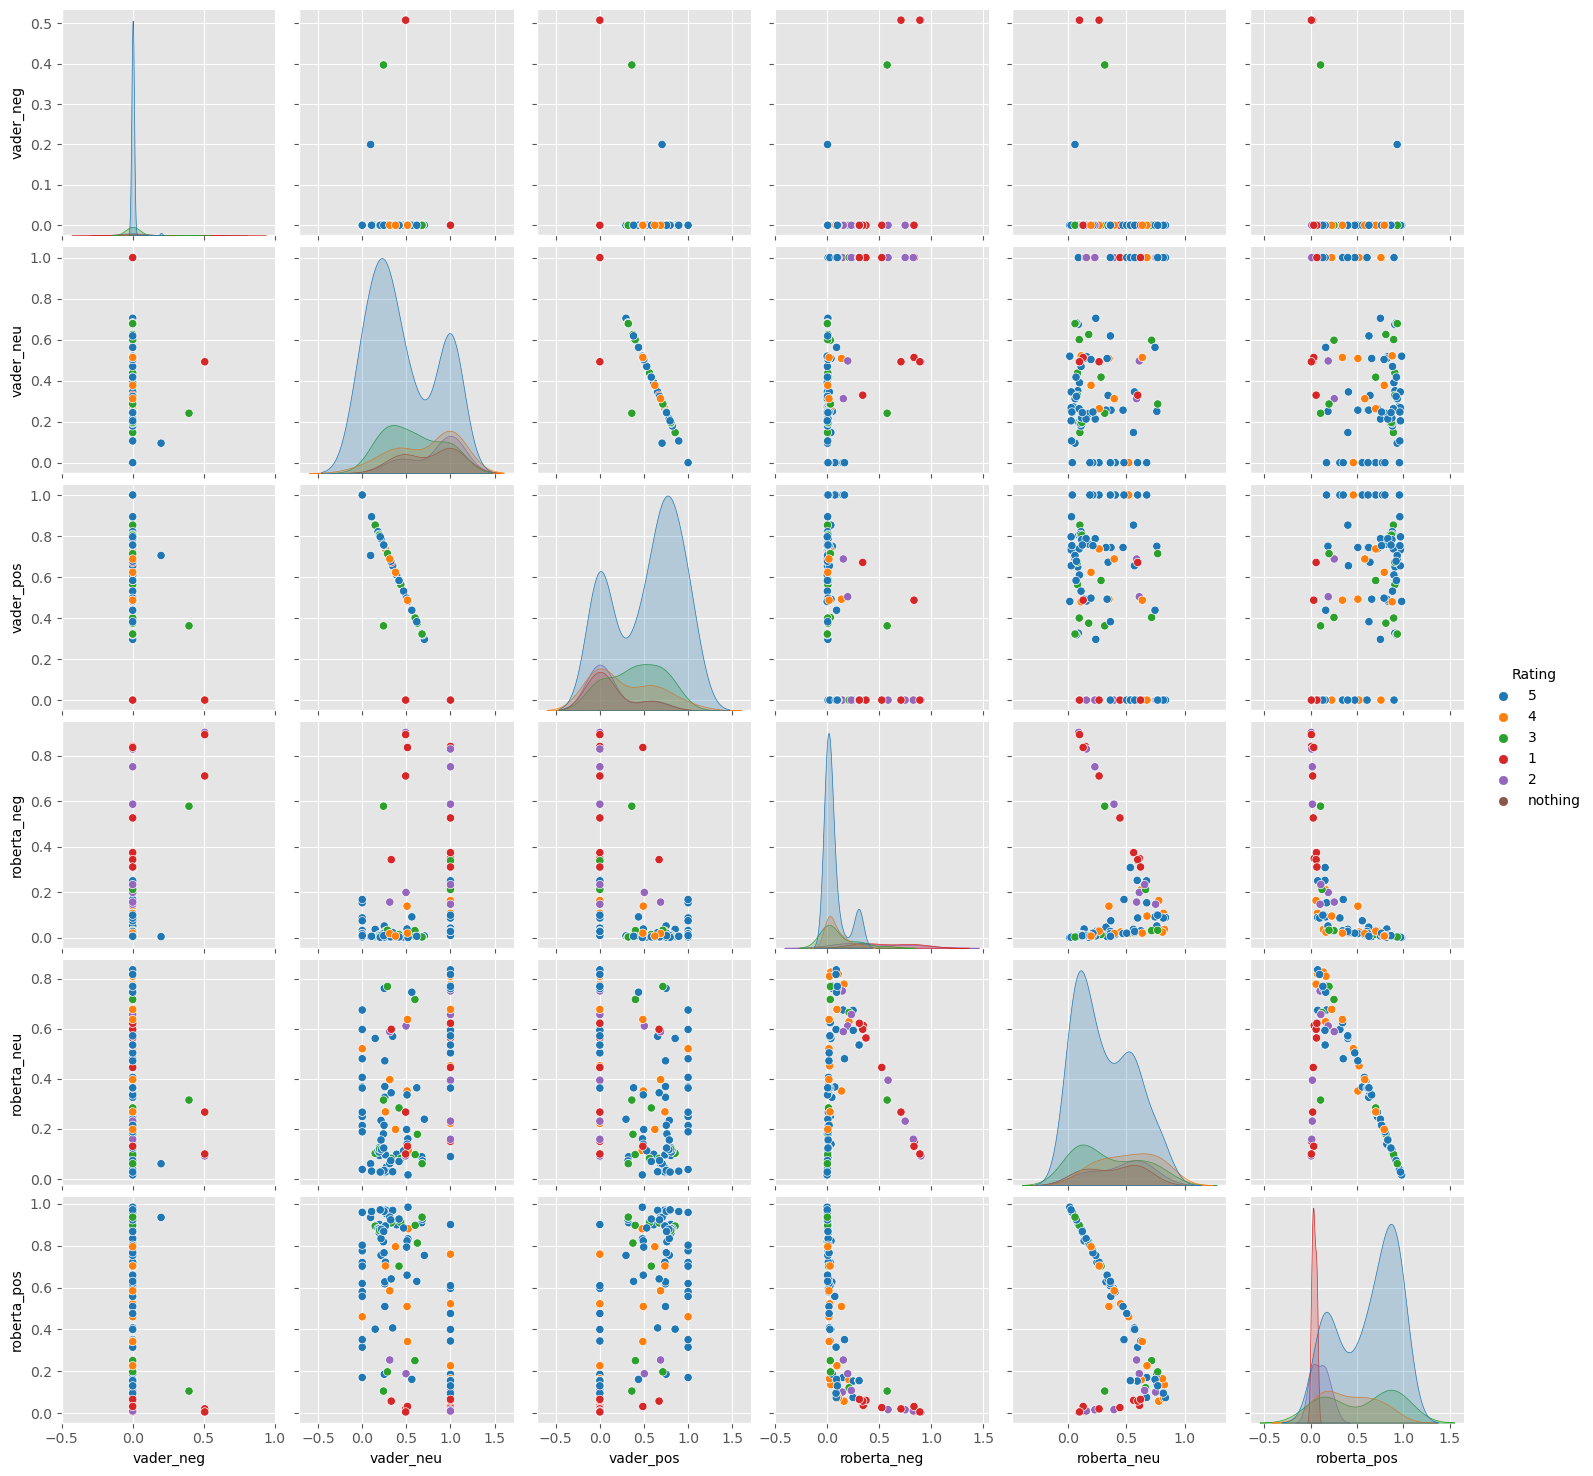

In [21]:
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='Rating',
            palette='tab10')
plt.show()